In [13]:
import pyro
import pyro.distributions
import pyro.poutine
from torch import tensor
import matplotlib.pyplot as plt

In [11]:
def fx(N):
    return N

def fy(N):
    return N

def fz(x, y, N):
    return N*(min(x,y))+(1-N)*(min(x+y,1))

def toymodel(noise):
    Nx = pyro.sample('Nx', noise['Nx'])
    Ny = pyro.sample('Ny', noise['Ny'])
    Nz = pyro.sample('Nz', noise['Nz']) 
    
    x = pyro.sample('x', pyro.distributions.Delta(fx(Nx)))
    y = pyro.sample('y', pyro.distributions.Delta(fy(Ny)))
    z = pyro.sample('z', pyro.distributions.Delta(fz(x, y, Nz)))
    return x, y, z

noise_prior = {'Nx': pyro.distributions.Bernoulli(tensor(.5)), 
               'Ny': pyro.distributions.Bernoulli(tensor(.5)),
               'Nz': pyro.distributions.Bernoulli(tensor(.5))}

10
20
30
40


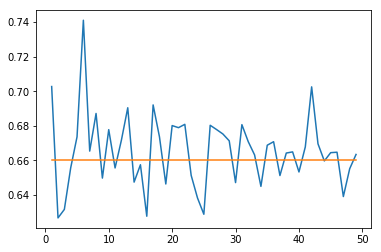

In [14]:
prob_nz_values = []
for i in range(1,50):
    observations = {'x': tensor(1.), 'z': tensor(1.)}
    conditioned_model = pyro.condition(toymodel, data = observations)
    posterior = pyro.infer.Importance(conditioned_model, num_samples= i*100)
    marginal = pyro.infer.EmpiricalMarginal(posterior.run(noise_prior), sites = 'Nz')
    prob_nz_values.append(1-marginal.mean.item())
    if i%10 == 0:
        print(i)

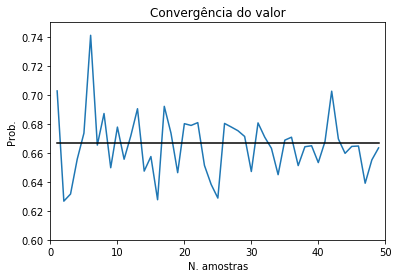

In [20]:
plt.title('Convergência do valor')
plt.ylabel('Prob.')
plt.xlabel('N. amostras')
plt.ylim([0.6, 0.75])
plt.xlim([0, 50])
plt.plot(list(range(1,50)), prob_nz_values)
plt.plot(list(range(1,50)), [0.6666 for i in range(1,50)], c='black')
plt.show()

In [23]:
prob_y_values = []
for i in range(1,50):
    observations = {'x': tensor(1.), 'z': tensor(1.)}
    conditioned_model = pyro.condition(toymodel, data = observations)
    posterior = pyro.infer.Importance(conditioned_model, num_samples= i*100)
    marginal = pyro.infer.EmpiricalMarginal(posterior.run(noise_prior), sites = 'y')
    prob_y_values.append(marginal.mean.item())
    if i%10 ==0:
        print(i)

10
20
30
40


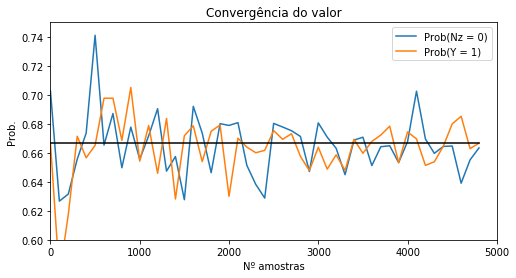

In [50]:
fig = plt.figure(figsize = (8,4))
plt.title('Convergência do valor')
plt.ylabel('Prob.')
plt.xlabel('Nº amostras')
plt.ylim([0.6, 0.75])
plt.xlim([0, 5000])
plt.plot(list(range(0,4900, 100)), prob_nz_values, label = "Prob(Nz = 0)")
plt.plot(list(range(0,4900, 100)), prob_y_values, label = "Prob(Y = 1)")
plt.plot(list(range(0,4900, 100)), [0.6666 for i in range(1,50)], c='black')
plt.legend()
plt.show()

In [43]:
cf_prob_z = []
for num_train in range(1,2000, 100):
    obsModel = pyro.condition(toymodel, {'x':tensor(1.), 'z':tensor(1.)})
    intModel = pyro.do(toymodel, {'x':tensor(0.)})
    posterior = pyro.infer.Importance(obsModel, num_samples = num_train).run(noise_prior)
    updatedNoise = {'Nx':pyro.infer.EmpiricalMarginal(posterior, sites = 'Nx'),
                    'Ny':pyro.infer.EmpiricalMarginal(posterior, sites = 'Ny'),
                    'Nz':pyro.infer.EmpiricalMarginal(posterior, sites = 'Nz')}
    counterfactual_posterior = pyro.infer.Importance(intModel, num_samples= num_train).run(updatedNoise)
    marginal_z = pyro.infer.EmpiricalMarginal(counterfactual_posterior, sites = 'z')
    cf_prob_z.append(marginal_z.mean)
    if num_train%100 == 1:
        print(num_train)

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901


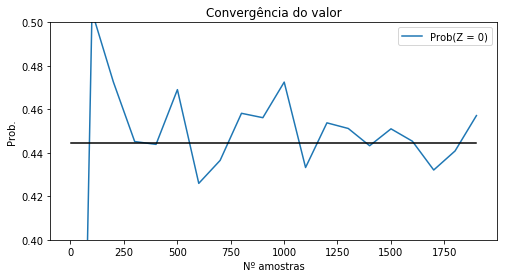

In [53]:
fig = plt.figure(figsize = (8,4))
plt.title('Convergência do valor')
plt.ylabel('Prob.')
plt.xlabel('Nº amostras')
plt.ylim([0.4, 0.5])
plt.plot(list(range(1,2000,100)), cf_prob_z, label = "Prob(Z = 0)")
plt.plot(list(range(1,2000,100)), [4/9 for i in range(1,2000,100)], c='black')
plt.legend()
plt.show()